In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
! ls ../eos/Mar23_2017

ls: ../eos/Mar23_2017: No such file or directory


In [3]:
presel = {
    "mu": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    }   
}

In [4]:
channels = ["mu"]
samples_dir = "../Mar23_2017"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
]

columns = [
    "lep_pt", 
    "lep_misolation", 
    "fj_ParT_mass", 
    "rec_higgs_m", 
    "fj_minus_lep_m",
]

In [5]:
events_dict = utils.event_skimmer(channels, samples_dir, samples, presel, columns, add_inclusive_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
applying pre-selection selection on 37594 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 37547 events
tot event weight 59643.87733479342 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
applying pre-selection selection on 109082 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 108956 events
tot event weight 1012.515525089713 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Applying preselection.
applying pre-selection selection on 1663 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parque

---> Applying preselection.
applying pre-selection selection on 15307 events
---> Done with preselection.
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 12836 events
tot event weight 1707125.2882783464 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Applying preselection.
applying pre-selection selection on 305006 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 300131 events
tot event weight 32779.98787521929 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Applying preselection.
applying pre-selection selection on 112069 events
---> Done with preselection.
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the

In [63]:
events_dict.keys()

dict_keys(['mu'])

In [64]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'HWW', 'QCD'])

## Get s/b

In [10]:
channels = ["mu"]

miso_cuts = [999999, 0.06, 0.08, 0.1, 0.12, 0.14, 0.18, 0.20, 0.22, 0.26]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}

    for miso_cut in miso_cuts:
        if miso_cut==999999:
            cut_label = "pre-selection"
        else:
            cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels (in this case only "mu")
            for sample in events_dict[ch]:

                df = events_dict[ch][sample]
                
                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                ### apply mini-isolation cut
                keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
                df = df.loc[keep, :]
                
                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                lep_fj_m = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (lep_fj_m>0) & (lep_fj_m<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in utils.signals:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for miso_cut in s[b4_or_af]:
        print(f"{miso_cut} : s/b = {s[b4_or_af][miso_cut]/math.sqrt(b[b4_or_af][miso_cut]):.3f}")
    print("-----------------------")                             

Before tagger cut:
pre-selection : s/b = 0.220
pre-selection + mini-iso<0.06 : s/b = 0.389
pre-selection + mini-iso<0.08 : s/b = 0.392
pre-selection + mini-iso<0.10 : s/b = 0.394
pre-selection + mini-iso<0.12 : s/b = 0.395
pre-selection + mini-iso<0.14 : s/b = 0.394
pre-selection + mini-iso<0.18 : s/b = 0.390
pre-selection + mini-iso<0.20 : s/b = 0.388
pre-selection + mini-iso<0.22 : s/b = 0.386
pre-selection + mini-iso<0.26 : s/b = 0.380
-----------------------
After tagger cut:
pre-selection : s/b = 0.420
pre-selection + mini-iso<0.06 : s/b = 0.680
pre-selection + mini-iso<0.08 : s/b = 0.686
pre-selection + mini-iso<0.10 : s/b = 0.691
pre-selection + mini-iso<0.12 : s/b = 0.692
pre-selection + mini-iso<0.14 : s/b = 0.692
pre-selection + mini-iso<0.18 : s/b = 0.690
pre-selection + mini-iso<0.20 : s/b = 0.685
pre-selection + mini-iso<0.22 : s/b = 0.686
pre-selection + mini-iso<0.26 : s/b = 0.676
-----------------------


In [13]:
channels = ["mu"]

miso_cuts = [0.1, 0.20]

qcd = {}
for b4_or_af in ["After tagger", "Before tagger"]:
    qcd[b4_or_af] = {}
    
    for miso_cut in miso_cuts:
        cut_label = f"pre-selection + mini-iso>{miso_cut:.2f}"
        qcd[b4_or_af][cut_label] = 0

        for ch in channels:   # sum over channels (in this case only "mu")
            df = events_dict[ch]["QCD"]

            ### apply tagger cut
            if b4_or_af == "After tagger":
                keep = ( df["inclusive_score"]>0.9 )
                df = df.loc[keep, :]

            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]>miso_cut ) )
            df = df.loc[keep, :]

            ### mass window
            lep_fj_m = df["fj_minus_lep_m"]     
            mass_window = (lep_fj_m>0) & (lep_fj_m<150)

            ### s/b
            ev_weight = df["event_weight"]        
            qcd[b4_or_af][cut_label] += ev_weight[mass_window].sum()    

for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for miso_cut in qcd[b4_or_af]:
        print(f"{miso_cut} : qcd = {qcd[b4_or_af][miso_cut]:.3f}")
    print("-----------------------")                             

Before tagger cut:
pre-selection + mini-iso>0.10 : qcd = 2130014.730
pre-selection + mini-iso>0.20 : qcd = 2068699.330
-----------------------
After tagger cut:
pre-selection + mini-iso>0.10 : qcd = 101064.122
pre-selection + mini-iso>0.20 : qcd = 98218.973
-----------------------


In [17]:
channels = ["mu"]

miso_cuts = [0.1, 0.2]

s, b = {}, {}
for b4_or_af in ["After tagger", "Before tagger"]:
    s[b4_or_af], b[b4_or_af] = {}, {}
    
    for miso_cut in miso_cuts:
        cut_label = f"pre-selection + mini-iso>{miso_cut:.2f}"

        s[b4_or_af][cut_label], b[b4_or_af][cut_label] = 0, 0

        for ch in channels:   # sum over channels (in this case only "mu")
            for sample in events_dict[ch]:

                df = events_dict[ch][sample]
                
                ### apply tagger cut
                if b4_or_af == "After tagger":
                    keep = ( df["inclusive_score"]>0.9 )
                    df = df.loc[keep, :]

                ### apply mini-isolation cut
                keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]>miso_cut ) )
                df = df.loc[keep, :]
                
                ### mass window
                regressed_mass = df["fj_ParT_mass"]     
                lep_fj_m = df["fj_minus_lep_m"]     
        #         mass_window = (regressed_mass>100) & (regressed_mass<150)
                mass_window = (lep_fj_m>0) & (lep_fj_m<150)

                ### s/b
                ev_weight = df["event_weight"]        
                if sample in ["QCD"]:
                    s[b4_or_af][cut_label] += ev_weight[mass_window].sum()
                else:
                    b[b4_or_af][cut_label] += ev_weight[mass_window].sum()    
                    
print("FOR s=QCD and b=others")
print("-----------------------")  

for b4_or_af in ["Before tagger", "After tagger"]:
    print(f"{b4_or_af} cut:")
    for miso_cut in s[b4_or_af]:
        print(f"{miso_cut} : s/b = {s[b4_or_af][miso_cut]/math.sqrt(b[b4_or_af][miso_cut]):.3f}")
    print("-----------------------")                             

FOR s=QCD and b=others
-----------------------
Before tagger cut:
pre-selection + mini-iso>0.10 : s/b = 8217.335
pre-selection + mini-iso>0.20 : s/b = 8316.382
-----------------------
After tagger cut:
pre-selection + mini-iso>0.10 : s/b = 902.323
pre-selection + mini-iso>0.20 : s/b = 915.812
-----------------------


# s/b as a function of the tagger cut

In [10]:
label_by_ch = {
    "mu": "Muon",
    "ele": "Electron"
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


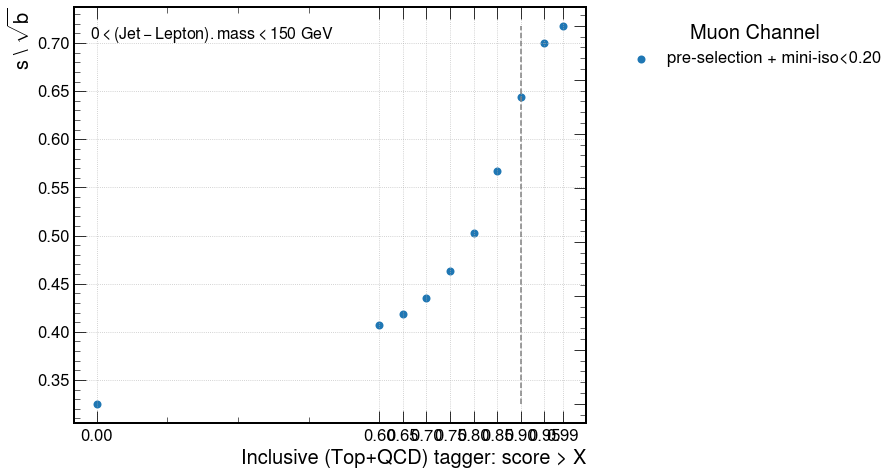

In [20]:
plt.rcParams.update({"font.size": 20})
channels = ["mu"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

miso_cuts = [0.2]
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"
    
    tagger_cuts = [0, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive_score"]

            mass_window = (df["fj_minus_lep_m"]>0) & (df["fj_minus_lep_m"]<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in utils.signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{label_by_ch[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$0<(Jet-Lepton).mass<150$ GeV", title_fontsize=16, loc=2)
plt.vlines(x=0.9, ymin=0, ymax=0.7, linestyle="--", color="grey")
plt.tight_layout()

In [19]:
ss/np.sqrt(bb)

array([0.33030843, 0.40257113, 0.41451424, 0.43196174, 0.46048976,
       0.50249386, 0.56795042, 0.65045608, 0.70070077, 0.70918491])

In [21]:
ss/np.sqrt(bb)

array([0.32509703, 0.40658053, 0.41816546, 0.43526701, 0.46276472,
       0.50276539, 0.56715294, 0.64386956, 0.70005241, 0.71779506])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


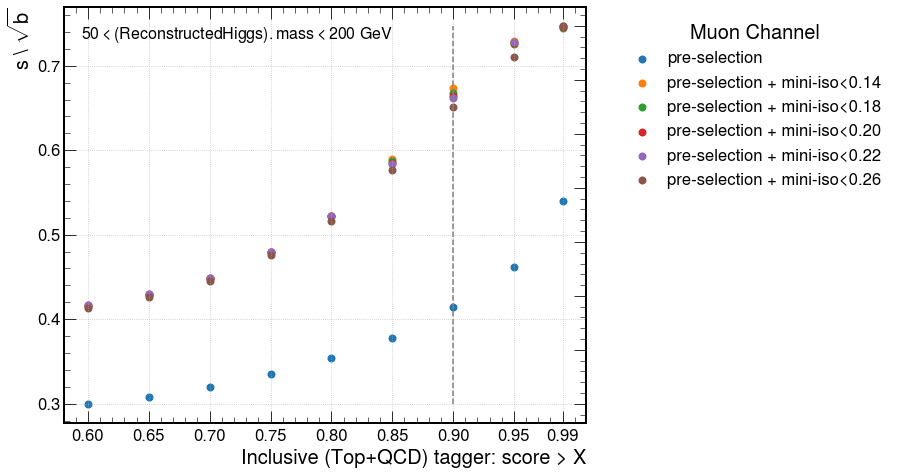

In [66]:
plt.rcParams.update({"font.size": 20})
channels = ["mu"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

miso_cuts = [999999, 0.14, 0.18, 0.20, 0.22, 0.26]
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"
    
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive_score"]
            
            mass_window = (df["rec_higgs_m"]>50) & (df["rec_higgs_m"]<200)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$50<(Reconstructed Higgs).mass<200$ GeV", title_fontsize=16, loc=2)
plt.vlines(x=0.9, ymin=0, ymax=0.7, linestyle="--", color="grey")
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


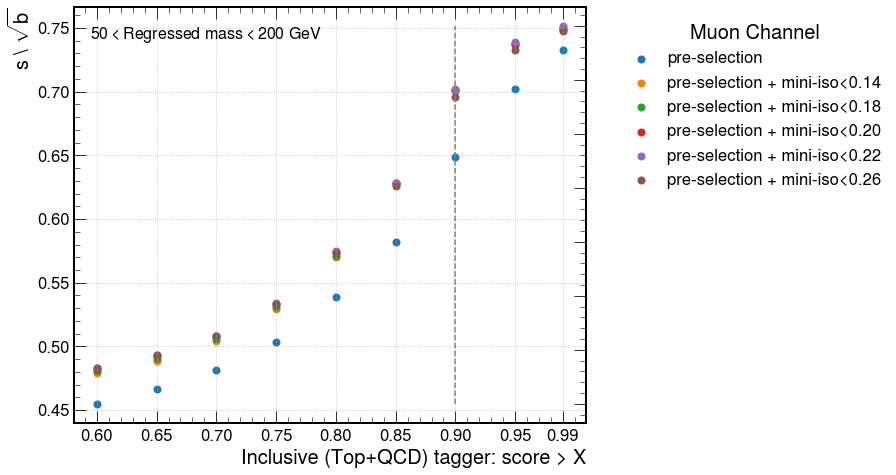

In [67]:
plt.rcParams.update({"font.size": 20})
channels = ["mu"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

miso_cuts = [999999, 0.14, 0.18, 0.20, 0.22, 0.26]
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"
    
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive_score"]
            
            mass_window = (df["fj_ParT_mass"]>50) & (df["fj_ParT_mass"]<200)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$50<$Regressed mass$<200$ GeV", title_fontsize=16, loc=2)
plt.vlines(x=0.9, ymin=0, ymax=0.7, linestyle="--", color="grey")
plt.tight_layout()